<a href="https://colab.research.google.com/github/RMilock/ComplexSpread/blob/main/Simple_SIR_ver12.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def sir(G, beta, mu, k = 1):
    'Number of nodes in the graph'
    N = G.number_of_nodes()
    
    'Label the individual wrt to the # of the node'
    node_labels = G.nodes()
    
    'Currently infected individuals and the future infected and recovered' 
    inf_list = [] 
    prevalence = []
    recovered = []

    'Initial Conditions'
    current_state = ['S' for i in node_labels] 
    future_state = ['S' for i in node_labels]
    
    random.seed(0)

    'Selects the seed of the disease'
    seeds = random.sample(range(N), k) 
    for seed in seeds:
      current_state[seed] = 'I'
      future_state[seed] = 'I'
      inf_list.append(seed)

    
    prevalence = [len(inf_list)/N]

    while(len(inf_list)>0):        
        
        'Infection Phase: each infected tries to infect all of the neighbors'
        for i in inf_list:
            'Select the neighbors of the infected node'
            tests = G.neighbors(i) #only != wrt to the SIS: contact are taken from G.neighbors            
            for j in tests:
                'If the contact is susceptible tries to infect it'
                if current_state[j] == 'S' and future_state[j] == 'S':
                    if random.random() < beta:
                        future_state[j] = 'I'
                    else:
                        future_state[j] = 'S'
                        
        'Recovery Phase: each infected in the current state recovers with probability mu'        
        for i in inf_list:
            if random.random() < mu:
                future_state[i] = 'R'
            else:
                future_state[i] = 'I'
        
        'Time update: once infections and recovery ended, we move to the next time-step'
        'The future state becomes the current one'
        current_state = future_state.copy() #w/o .copy() it's a mofiable-"view"
       
        'Updates inf_list with the currently fraction of inf/rec' 
        inf_list = [i for i, x in enumerate(current_state) if x == 'I']
        rec_list = [i for i, x in enumerate(current_state) if x == 'R']

        
        'Saves the fraction of infected and recovered in the current time-step'

        prevalence.append(len(inf_list)/float(N))
        recovered.append(len(rec_list)/float(N))
 
    return prevalence, recovered

def plot_sir(G, beta, mu, k):
  'plot ratio of daily infected and daily cumulative recovered'
  prevalence, recovered = sir(G, beta, mu, k)
  plt.plot(prevalence, label="Infected/N")
  plt.plot(recovered, label="Recovered/N")


  'plot horizontal line to highlight the initial infected'
  plt.axhline(k/N, color = "r", ls="dashed", label = "Starting Infecteds /N")
  locs, labels = plt.yticks()
  locs_yticks = np.array([])
  for i in range(len(locs)): 
      if locs[i] <= k/N < locs[i+1]:  
          locs_yticks  = np.concatenate((locs[1:i+1], [k/N], locs[i+1:-1])) #omit the 1st and last for better visualisation
  plt.yticks(locs_yticks, np.round(locs_yticks,3))


  'plot labels'
  plt.xlabel('Time', fontsize = 16)
  plt.ylabel('Indivs/N', fontsize = 16)
  plt.legend(loc="best");

'Net Infos'
def sorted_nodes_adj_degree(G):
    'sort nodes by key = degree. printing order: node, adjacent nodes, degree'
    nodes = G.nodes()
    print("Sum_i k_i: ", np.sum([j for (i,j) in G.degree() ]), \
          " and <k>: ", np.sum([j for (i,j) in G.degree() ]) / len(nodes), end="\n\n" )
    
    'put adj_matrix into dic from better visualisation'
    adj_matrix =  nx.adjacency_matrix(G).todense()
    adj_dict = {i: np.nonzero(row)[1].tolist() for i,row in enumerate(adj_matrix)}

    infos = zip([x for x in nodes], [adj_dict[i] for i in range(len(nodes))], [G.degree(x) for x in nodes])
    inner_sorted_nodes = sorted( infos, key = lambda x: x[2])
    for i in range(len(nodes)):
      print( inner_sorted_nodes[i] )

In [ ]:
import random
import networkx as nx
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product

np.set_printoptions(precision=4, suppress=True)

#make the axes white
params = {"ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k",
        "axes.titlecolor":"k"}
plt.rcParams.update(params)

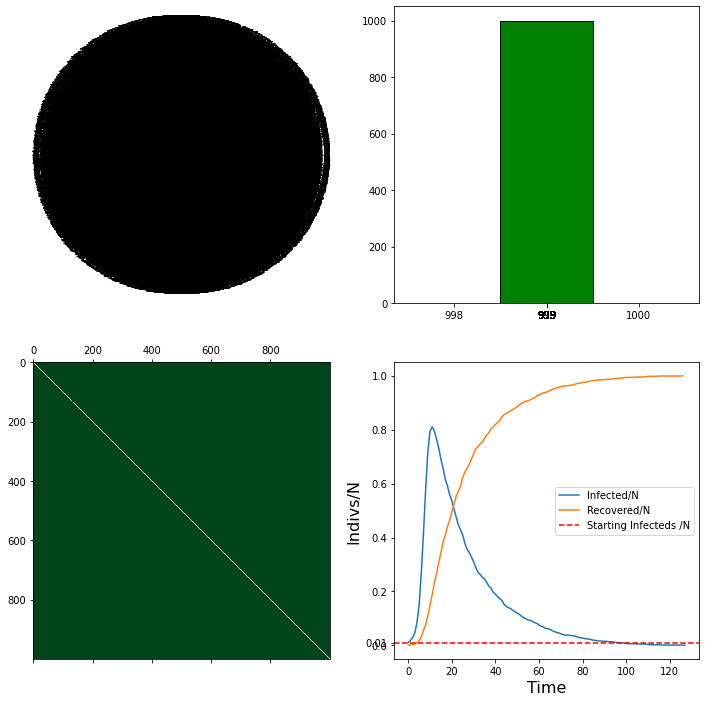

In [ ]:
N = int(1e3); cut_off = 0; k = 10
G = nx.Graph(); 
beta = 1e-3 # infection probability. MF_SIR: beta = 1e-3
mu = 0.05 # recovery probability. MF_SIR: mu = 0.05

edges = set()
'Add nodes to form a fully connected network'
for i,j in product(range(N), repeat=2):
  if i != j%N: # since i,j "run freely", we have 2p of chance of edging. So, the mean=n*2p
    edges.add((i,j))

G.add_edges_from(edges)

def plot_G_degdist_adjmat_sir(G, figsize = (12,12)):

  fig, axs = plt.subplots(2,2, figsize = figsize)
  nx.draw_circular(G, ax=axs[0,0], with_labels=True, font_size=12, node_size=5, width=.3)

  'plot the degrees distribution and center the bins to the degree'
  degrees = [G.degree(n) for n in G.nodes()]
  'begin with k_min-1; finish [k_max+1,k_max+2] at the end. for better visualization'
  bins = np.sort(degrees); bins = np.insert(bins, 0, bins[0]-1); bins = np.append(bins, np.array([bins[-1]+1, bins[-1]+2]) )
  
  'set xticks to be centered'
  n, hist_bins, patches = axs[0,1].hist(degrees, bins=bins, log=False, density=0, color="green", ec="black", lw=1, align="left")
  axs[0,1].set_xticks(hist_bins[:-1])   

  'plot adjiacency matrix'
  adj_matrix = nx.adjacency_matrix(G).todense()
  axs[1,0].matshow(adj_matrix, cmap=plt.cm.Greens)

  'plot sir'
  plot_sir(G, beta, mu, k)

plot_G_degdist_adjmat_sir(G)

plot_name = "Fully_Connected_Network"+ ".pdf"; plt.savefig(plot_name)
plt.show()

# Start Pruning the Net

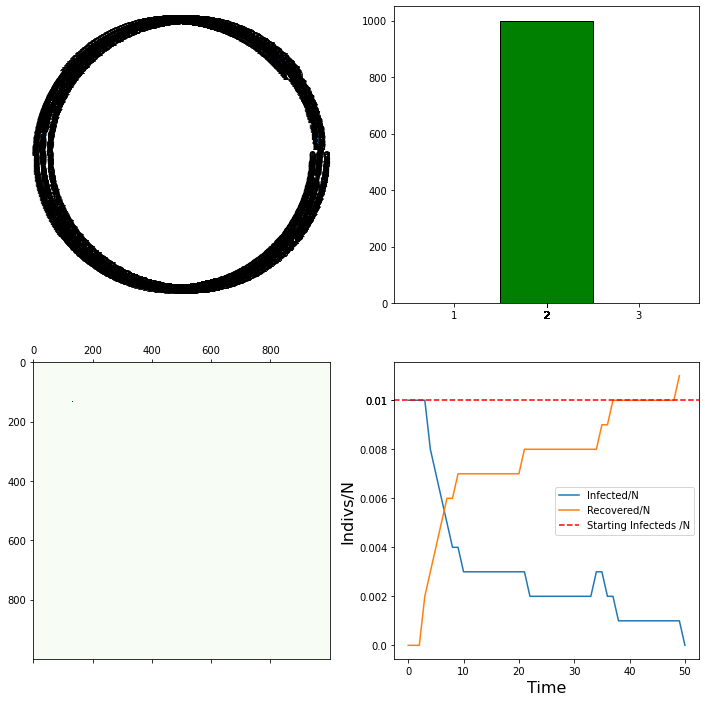

In [ ]:
'''
Independetly on the rewiring of the graph, I need to remove the "most far" nodes.
- since my work would be based on a circular layout, I find the "most far" by using hops to reach a node in the cycle_graph;
- number_left_links is found by "round_down" the approximation;
- not to connect clock-wise via the same previous link, use "list_cicled" to connect "forward. 
Other way around, use L = nodes and N = 8; but adj.matrix changes.
'''
def circ_diam(G): 
    n = nx.number_of_nodes(G)
    if n % 2 == 0: return int(n/2)
    elif n % 2 == 1: return int( (n-1)/2 )

def cy_dist(i,j): return nx.shortest_path_length(nx.cycle_graph(N), source = i, target = j)

def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

def nl_links(N, nr):
    rounded = round_down(N-1 - nr_links)
    if rounded % 2 == 1: return rounded -1
    return rounded

def list_cicled(L, start = None, length = None):
    from itertools import cycle, islice, dropwhile
    if length == None: length = len(L)
    if start == None: start = L[0]
    
    cycled = cycle(L)  # indefinetely-cycle thorugh the list 'L'
    skipped = dropwhile(lambda x: x != start, cycled)  # drop the values until x == start
    sliced = islice(skipped, None, length)  # islice('ABCDEFG', start = 0, stop = None, step = 2) --> A C E G
    return list(sliced)

'G.clear all nodes and edges and start rewiring'
G.clear()
G = nx.cycle_graph(N, create_using=None)
plot_G_degdist_adjmat_sir(G)


Total Links: 999; nr_links: 799.2; nl_links (if N is even--round_down): 199.0
{(621, 577), (342, 418), (381, 392), (418, 370), (312, 241), (789, 865), (842, 874), (284, 367), (323, 275), (747, 795), (270, 302), (733, 708), (242, 161), (929, 983), (638, 579), (424, 521), (647, 549), (119, 90), (156, 192), (781, 755), (527, 499), (714, 726), (368, 358), (326, 291), (365, 327), (296, 338), (921, 833), (388, 386), (812, 906), (653, 650), (985, 74), (895, 971), (731, 634), (971, 43), (528, 572), (514, 611), (198, 248), (491, 398), (622, 640), (779, 845), (193, 280), (818, 813), (857, 817), (179, 221), (804, 744), (550, 508), (112, 200), (737, 731), (338, 390), (391, 400), (84, 102), (709, 661), (31, 953), (70, 81), (469, 556), (628, 539), (40, 4), (455, 521), (614, 530), (12, 90), (879, 906), (715, 669), (330, 373), (224, 208), (277, 330), (316, 288), (740, 824), (196, 286), (235, 304), (272, 198), (475, 449), (936, 877), (221, 253), (991, 905), (177, 127), (417, 456), (126, 42), (96, 9), (

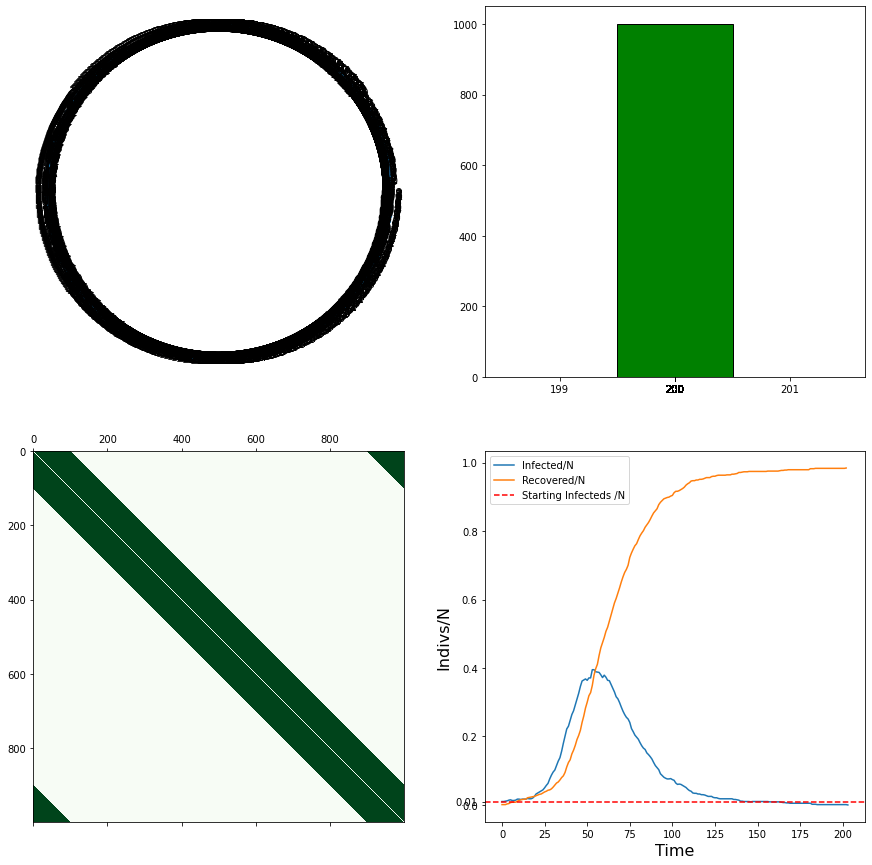

In [ ]:
'set number of removed and left nodes. NB: If nl is odd, the effective links are nl_links+1, since the net is periodic'
nr_links = (N-1)*0.8; nl_links = round_down(N-1 - nr_links)

count = 0; nodes = [x for x in G.nodes()]

print("Total Links: {0}; nr_links: {1}; nl_links (if N is even--round_down): {2}".format(len(nodes)-1, nr_links, nl_links))

'impose nl_links via NNAR (nearest neighbors anticlock-wise re-wiring)'
G.remove_edges_from(G.edges())
edges = set()

def modN(x): return x % N 

for i in nodes:
  for j in range(1, int(nl_links//2)+1):
    edges.add(( i,modN(i+j) )); edges.add( (i,modN(i-j)) )
    if nl_links % 2 == 1.0: edges.add( (i,modN(i+j+1)) );
print(edges)


G.add_edges_from(edges)


'plot G, degree distribution and the adiaciency matrix'
plot_G_degdist_adjmat_sir(G, figsize = (15,15))    


plt.show()